In [47]:
import os 
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sys
sys.path.append('../..')
from data.data_loader import get_splits



#data = pd.read_csv("../../data/vehicles_cleaner.csv", names = ["City","Price","Year","Make","Model","Condition","Cylinders","Gas type","Odometer","Title status","Transmission type","Drive type","Size","Car type","Color","State"])
#data=data.drop('City',1)
data = get_splits('../../data/vehicles_cleaner.csv', 0.2)
#display(data)

"""new_data = data[data['Model'] != 'NOTVALID']
display(new_data['Model'])
price_data=new_data['Price']
features_data=new_data.drop('Price',1)"""



"""x = features_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
features_data = pd.DataFrame(x_scaled)
display(features_data)"""
X_train = data['X_train']
y_train = data['Y_train']
X_test = data['X_test']
y_test = data['Y_test']

display(X_train)
display(y_train)
display(X_test)
display(y_test)

scaler = MinMaxScaler() 
# It resizes to 0-1 for easier processing of data.
numerical = ['year', 'make', 'model','condition','cylinders','fuel','odometer', 'title_status','transmission','drive','size','type','paint_color','state']
X_train[numerical] = scaler.fit_transform(X_train[numerical])   
# Creating dummy variables for categorical data.
#features_data = pd.get_dummies(features_data)  
encoded = list(X_train.columns) 
display("There are {} features after one hot encoding".format(len(encoded))) 
display(encoded)

# It resizes to 0-1 for easier processing of data.
numerical = ['year', 'make', 'model','condition','cylinders','fuel','odometer', 'title_status','transmission','drive','size','type','paint_color','state']
X_test[numerical] = scaler.fit_transform(X_test[numerical])   
# Creating dummy variables for categorical data.
#features_data = pd.get_dummies(features_data)  
encoded = list(X_test.columns) 
display("There are {} features after one hot encoding".format(len(encoded))) 
display(encoded)

X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

# Show the results of the split
print("The train set has an example of {}.".format(X_train.shape[0]))
print("Validation set has an example of {}.".format(X_val.shape[0]))
print("The test set has an example of {}.".format(X_test.shape[0]))

X_train=np.array(X_train) #lists are converted to numpy arrays
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)
X_test=np.array(X_test)
y_test=np.array(y_test)


,year,make,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
4168,12,4,2,3,3,0,121862.0,1,2,0,-1,3,10,5
929,4,4,10,-1,-1,0,42388.0,0,1,-1,-1,-1,-1,49
9473,3,4,8,-1,1,0,10909.0,0,1,0,-1,2,-1,32
8823,5,4,12,-1,-1,0,40347.0,0,1,-1,-1,2,0,30
823,6,4,4,-1,-1,0,103829.0,0,1,-1,-1,-1,-1,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359,15,4,12,-1,-1,0,154371.0,0,1,-1,-1,2,6,12
20,6,4,2,-1,1,0,71543.0,0,1,2,-1,3,4,44
707,4,4,1,-1,1,0,18722.0,0,1,0,-1,7,-1,47
2182,6,4,21,-1,-1,0,60000.0,2,1,-1,-1,-1,-1,4


4168     4980
929     21950
9473    28995
8823    24491
823     15450
        ...  
6359     6990
20      16795
707     23500
2182    38999
1752    21491
Name: price, Length: 8613, dtype: int64

,year,make,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
11336,6,4,26,2,3,0,116014.0,0,1,0,1,2,0,39
6698,6,4,12,-1,4,0,68269.0,0,1,-1,-1,2,1,16
3735,15,4,18,-1,-1,0,127898.0,0,0,-1,3,7,4,4
1908,4,4,2,2,-1,0,12491.0,0,1,2,-1,3,4,4
11008,17,4,4,2,3,0,105408.0,0,1,2,-1,3,4,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,7,4,4,2,1,0,57000.0,0,1,2,1,3,1,4
5512,8,4,2,2,-1,0,73500.0,0,1,2,-1,8,1,9
3022,9,4,0,1,3,0,65000.0,0,1,2,0,7,0,4
5038,8,4,4,2,1,0,108462.0,0,1,2,1,3,1,9


11336    12995
6698     25995
3735     18999
1908     25985
11008     5350
         ...  
3307     17500
5512     11495
3022      1500
5038     11950
7257      7995
Name: price, Length: 2154, dtype: int64

'There are 14 features after one hot encoding'

['year',
 'make',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

'There are 14 features after one hot encoding'

['year',
 'make',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

The train set has an example of 6459.
Validation set has an example of 2154.
The test set has an example of 2154.


In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, Callback
from keras import backend
#from tensorflow.keras import backend

# Lost function is selected as mean absolute error
loss_function='mean_absolute_error'
# The sequential model is created to use compile-fit-evaluate-predict methods
price_predictor = Sequential()
# Neural network layers are created with RELU activation
price_predictor.add(Dense(128,activation='relu', input_dim=14))  
price_predictor.add(Dense(64))
price_predictor.add(Dense(32,activation='relu'))
price_predictor.add(Dense(8))
price_predictor.add(Dense(1))
price_predictor.summary()

# Here the Adam optimizer (different type of stochastic gradient descent) is used.
price_predictor.compile(optimizer='Adam', loss=loss_function)

# It allows new callbacks by abstracting the base class.
checkpointer = ModelCheckpoint(filepath='price_prediction.hdf5', verbose=1, save_best_only=True)

# Trains the model according to the number of epoch given.
#price_predictor.fit(X_train, y_train, validation_data=[X_val,y_val], epochs=20, batch_size=500, callbacks=[checkpointer], verbose=0) 
price_predictor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=500, callbacks=[checkpointer], verbose=0)

price_predictor.load_weights('price_prediction.hdf5')
score=price_predictor.evaluate(X_test,y_test,verbose=1)
display("The final model scores {} for test data.".format(score))

price_prediction=price_predictor.predict(X_test)

"""model = Sequential([
    Dense(85, activation='relu', input_shape=(1079,)),
    Dense(85, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(X_train, y_train,
          batch_size=32, epochs=10,
          validation_data=(X_val, y_val))"""





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1920      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 12,529
Trainable params: 12,529
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 14497.51718, saving model to price_prediction.hdf5

Epoch 00002: val_loss improved from 1449

'The final model scores 7837.069954336409 for test data.'

"model = Sequential([\n    Dense(85, activation='relu', input_shape=(1079,)),\n    Dense(85, activation='relu'),\n    Dense(1, activation='sigmoid'),\n])\n\nmodel.compile(optimizer='sgd',\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\n\n\nmodel.fit(X_train, y_train,\n          batch_size=32, epochs=10,\n          validation_data=(X_val, y_val))"

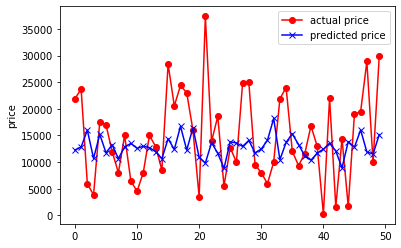

In [46]:
num_samples=50
idx=random.sample(range(len(y_test)),num_samples) 
plt.plot(range(num_samples),y_test[idx],'ro-')
plt.plot(range(num_samples),price_prediction[idx],'bx-')
plt.ylabel("price")
plt.legend(["actual price",'predicted price','mean price'])

In [2]:
dictData = {}
dictData['X_train'] = X_train
dictData['X_test'] = X_test
dictData['Y_train'] = y_train
dictData['y_test'] = y_test


In [4]:
display(dictData['Y_train'])

array([4250, 3900, 1290, ..., 5900, 3450, 4000])

In [6]:
display(dictData['y_test'])

array([11500,  5950,  8950, ...,  1300,  6000,  1800])